# Forecasting Retail Demand with Vertex AI and BQML 

## Table Of Contents
* [OVERVIEW](#section-1)
* [Dataset](#section-2)
* [Objective](#section-3)
* [Copy the required file paths from the GCS file browser](#section-4)
* [Exploratory Data Analysis](#section-5)
* [Load Data into BigQuery](#section-6)
* [Model with BigQuery and the ARIMA model](#section-7)
* [Evaluate the model](#section-8)
	* [Evaluate the Model Results using BQML (on Training Data)](#section-8-subsection-1)
	* [Evalute the Model Results - MAE, MAPE, MSE, RMSE (on Test data)](#section-8-subsection-2)

## Overview 
<a name="section-1"></a>


In this notebook, we explore demand forecasting using real sales data provided by Walmart. Being able to measure and forecast customer demand can help retailers better understand their customers, stock shelves with the right products, offer targeted promotions, and generally, better plan and manage their budgets. We apply an ARIMA model (Autoregressive integrated moving average) from BQML on Walmart's historical sales data. The full dataset can be found on <a href="https://www.kaggle.com/c/m5-forecasting-accuracy/data?select=sales_train_evaluation.csv">Kaggle</a> and information on BQML can be found here. This notebook demonstrates how to load data from GCS into notebooks and train and evaluate a BQML model for demand forecasting datasets, extract actionable future insights.

You have to follow this steps before going through this notebook inside Vertex-AI notebook instance :
* Load data into a GCS bucket
* Create a managed notebook instance in Vertex-AI with python3 ("NumPy/SciPy/scikit-learn") environment on a n1-standard4 instance.


#### ARIMA Modeling with BQML 

The <a href='https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average'>ARIMA model</a> is designed to analyze historical data, spot patterns over time, and project them into the future, i.e. forecasting. The model is available inside BigQuery ML and enables users to create and execute machine learning models directly in BigQuery using SQL queries. Working with BQML is advantageous, as it already has access to the data, it can handle most of the modeling details automatically if desired, and will store both the model and any predictions also inside BigQuery. 


## Dataset 
<a name="section-2"></a>

This notebook uses the "Walmart Recruiting - Store Sales Forecasting" data set.
The data covers stores in three US States (California, Texas, and Wisconsin) and includes item level, department, product categories, and store details. In addition, it has explanatory variables such as price, promotions, day of the week, and special events. 

It is available in <a href="https://www.kaggle.com/c/m5-forecasting-accuracy/data?select=sales_train_evaluation.csv">Kaggle</a>. 
It comprises location information like the state, store and department number, store size, and store type. It lists temporal data such as sales date, temperature,  CPI, unemployment data, if it's a holiday for each sale. And it contains sale information with a category and sale count per day - which is the outcome variable that our model will explore.

The data shows information at the state level but everything underneath is anonymized.

## Objective
<a name="section-3"></a>
* Set up your development environment
* Copy the required file paths from the GCS file browser
* Exploratory Data Analysis
* Load Data into BigQuery
* Model with BigQuery and the ARIMA model
* Evaluate the model
* Evaluate the Model Results using BQML (on Training Data)
* Evalute the Model Results - MAE, MAPE, MSE, RMSE (on Test data)

## Before you begin

**Note:** This notebook does not require a GPU runtime.

### Set up your Google Cloud project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

1. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

1. [Enable the Vertex AI, Cloud Storage, and Compute Engine APIs](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com,compute_component,storage-component.googleapis.com). 

1. Follow the "**Configuring your project**" instructions from the Vertex Pipelines documentation.

1. If you are running this notebook locally, you will need to install the [Cloud SDK](https://cloud.google.com/sdk).

1. Enter your project ID in the cell below. Then run the cell to make sure the
Cloud SDK uses the right project for all the commands in this notebook.

**Note**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$` into these commands.

#### Set your project ID

**If you don't know your project ID**, you may be able to get your project ID using `gcloud`.

In [1]:
import os
PROJECT_ID = ""

# Get your Google Cloud project ID from gcloud
if not os.getenv("IS_TESTING"):
    shell_output=!gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID: ", PROJECT_ID)

Project ID:  vertex-ai-dev


Otherwise, set your project ID here.

In [2]:
if PROJECT_ID == "" or PROJECT_ID is None:
    PROJECT_ID = "[your-project-id]"  # @param {type:"string"}

#### Timestamp

If you are in a live tutorial session, you might be using a shared test account or project. To avoid name collisions between users on resources created, you create a timestamp for each instance session, and append it onto the name of resources you create in this tutorial.

In [3]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

## Import libraries and define constants

Load the required libraries

In [4]:

import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
from google.cloud.bigquery import Client, QueryJobConfig
import datetime
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Copy the required file paths from the GCS file browser
<a name="section-4"></a>


To select the required files from GCS, newly integrated GCS file browser can be used. After locating the file paths, set the path variables for pandas to read the file.

<img src="images/gcs_file_browser.png">

Define the constants


In [5]:
PROJECT_ID = ''
REGION = '[your-region]'
DATASET = '[your-dataset-name]'
SALES_TABLE = '[your-bigquery-table-name]'

## select the required file-paths from the GCS file-browser
GCS_FILE1_PATH = "path to sales_train_evaluation file"
GCS_FILE2_PATH = "path to calendar file"


Read the data from the defined GCS file paths


In [6]:
sales_data= pd.read_csv(GCS_FILE1_PATH)
calendar= pd.read_csv(GCS_FILE2_PATH)
print (calendar.shape)
print (sales_data.shape)

(1969, 14)
(30490, 1947)


You must save the data to Bigquery first. Then we explore the new features of Bigquery magic to analyse and process the data in bigquery itself.

#@bigquery
-- create a dataset in Bigquery
CREATE SCHEMA demand_forecasting
OPTIONS(
  location="us"
  )

## Exploratory Data Analysis 
<a name="section-5"></a>


Check the columns in the calendar data

In [7]:
calendar.columns

Index(['date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'd',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI'],
      dtype='object')

Check percentage of null values in the calendar data

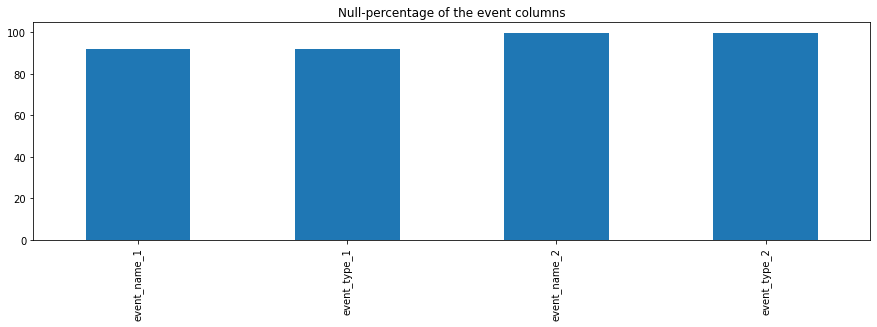

In [8]:
(100*calendar[["event_name_1","event_type_1","event_name_2","event_type_2"]].isna().sum()/calendar.shape[0]).plot.bar(figsize=(15,4))
plt.title("Null-percentage of the event columns")
plt.show()

Since the event columns mostly(>90%) consist of null data, ignore them...

In [9]:
cal_cols_trimmed = ['date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'd']

Check unique items in the dataset

In [10]:
print (sales_data["item_id"].unique().shape)

(3049,)


Filter all day columns

In [11]:

day_columns = sales_data.filter(regex='^d_',axis=1).columns.to_list()
categ_columns = ["item_id","dept_id","cat_id","store_id","state_id"]
print (len(day_columns))

1941


Plot a sample time-series for an item-id (a single row)

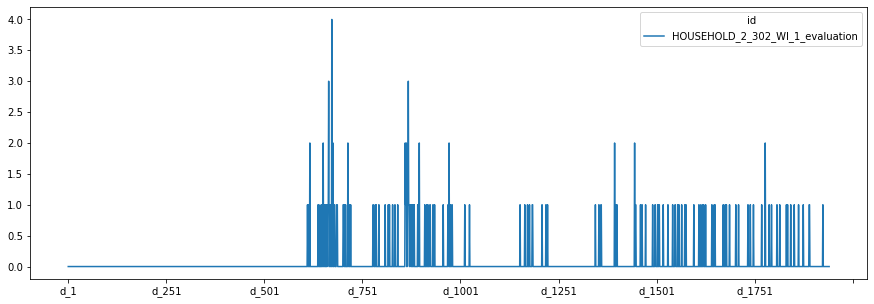

In [12]:

sample = sales_data.sample(1)
sample.set_index('id')[day_columns].T.plot(figsize=(15,5), style='-')
plt.show()

Check how many time series the dataset contains

In [13]:
 
print (sales_data["state_id"].value_counts())
print (sales_data["store_id"].value_counts())
print (sales_data["cat_id"].value_counts())
print (sales_data["dept_id"].value_counts())

CA    12196
TX     9147
WI     9147
Name: state_id, dtype: int64
CA_1    3049
CA_2    3049
CA_3    3049
CA_4    3049
TX_1    3049
TX_2    3049
TX_3    3049
WI_1    3049
WI_2    3049
WI_3    3049
Name: store_id, dtype: int64
FOODS        14370
HOUSEHOLD    10470
HOBBIES       5650
Name: cat_id, dtype: int64
FOODS_3        8230
HOUSEHOLD_1    5320
HOUSEHOLD_2    5150
HOBBIES_1      4160
FOODS_2        3980
FOODS_1        2160
HOBBIES_2      1490
Name: dept_id, dtype: int64


So you have the following characteristics in the data:
    * 3 States
    * 9 Stores ( 3 for each State)
    * 3 Categories
    * 6 Departments ( 3 Foods, 2 Households, 1 Hobbies)
    * 3049 unique items as a total from all the departments
    
For our time-series analysis, you can go through various ways. For example, you can try to forecast sales at state level, at store level, at state and category level, at category level etc. For the current use-case, lets pick forecasting sales at Store and item-level. We'll be picking up one store-id and will be forecasting the sales at item-level for that store.

Lets just select data for one store location

In [14]:

sales_data_ca1 = sales_data[sales_data["store_id"]=="CA_1"]
sales_data_ca1.shape

(3049, 1947)

We have 3049 unique items and for each item, we have sales for 1947 days.
Lets melt the data so that we can get the data into a format which can be used for training using BQML


In [15]:
sales_data_ca1 = sales_data_ca1[['id']+categ_columns+day_columns].copy()
sales_data_ca1 = pd.melt(sales_data_ca1, id_vars=['id']+categ_columns, value_vars=day_columns,var_name='d', value_name='sales_count')
print (sales_data_ca1.shape)

(5918109, 8)


Join the sales data with the calendar information on the day column


In [16]:
sales_data_ca1 = sales_data_ca1.merge(calendar[cal_cols_trimmed+["snap_CA"]],how="left",on="d",validate='m:1')
sales_data_ca1.shape

(5918109, 15)

Check the data


In [17]:
sales_data_ca1.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales_count,date,wm_yr_wk,weekday,wday,month,year,snap_CA
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,0


Plot the sales over the dates for an item

<AxesSubplot:xlabel='date'>

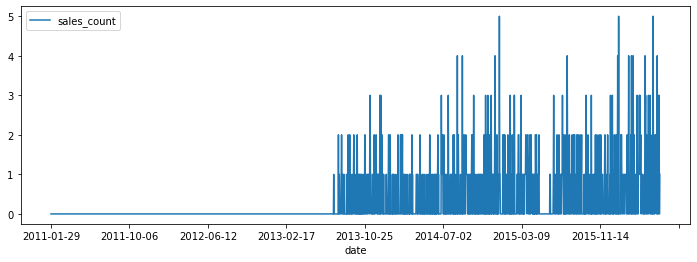

In [18]:

sales_data_ca1[sales_data_ca1["item_id"]=="HOBBIES_1_001"][["date","sales_count"]].set_index("date").plot(figsize=(12,4))

Select required columns for training


In [19]:
sales_data_ca1 = sales_data_ca1[["item_id","date","sales_count"]]
sales_data_ca1.shape

(5918109, 3)

Convert the time columns to datetime dtype


In [20]:
sales_data_ca1["date"] = pd.to_datetime(sales_data_ca1["date"], format="%Y-%m-%d")

## Loading data into BigQuery
<a name="section-6"></a>


Save the training data to table in the created dataset


In [21]:
bq_client = bigquery.Client(project=PROJECT_ID)

job_config = bigquery.LoadJobConfig(
    # Specify a (partial) schema. All columns are always written to the
    # table. The schema is used to assist in data type definitions.
    schema=[
        bigquery.SchemaField("item_id", bigquery.enums.SqlTypeNames.STRING),
        bigquery.SchemaField("date", bigquery.enums.SqlTypeNames.DATE),
        bigquery.SchemaField("sales_count", bigquery.enums.SqlTypeNames.INTEGER),
    ],
    # Optionally, set the write disposition. BigQuery appends loaded rows
    # to an existing table by default, but with WRITE_TRUNCATE 
    # write_disposition it replaces the table with the loaded data.
    write_disposition="WRITE_TRUNCATE",
)

## save the dataframe to a table in the created dataset
job = bq_client.load_table_from_dataframe(
    sales_data_ca1,
    "{}.{}.{}".format(PROJECT_ID, DATASET, SALES_TABLE),
    job_config=job_config
)  # Make an API request.
job.result()  # Wait for the job to complete.


After the above job completes, the Bigquery file browser can be refreshed to ensure the table has been created.

<img src="images/bq_save_table.png">

Separate out training data for a specific time period from the sales data into a table and create a training table for the top 5 items for the selected time period.

#@bigquery
CREATE OR REPLACE TABLE demand_forecasting.training_data AS (
    WITH topsellingitems AS(
         SELECT 
            item_id,
            sum(sales_count) sum_sales
        FROM
            demand_forecasting.sales_data
        GROUP BY 
            item_id
        ORDER BY sum_sales DESC
        LIMIT 5 #Top N
    )
    
-- select the data from the table created
    SELECT 
        date,
        item_id,
        sales_count
    FROM
        demand_forecasting.sales_data
    WHERE
        date BETWEEN '2011-02-01' AND '2015-02-01'
        AND item_id IN (SELECT item_id FROM topsellingitems)
    );

Query and load as DataFrame button can be used to load the data from the query into a dataframe. This would add a python snippet in the next cell as following. This step is optional.

In [22]:

client = Client()

query = """CREATE OR REPLACE TABLE demand_forecasting.training_data AS (
    WITH topsellingitems AS(
         SELECT 
            item_id,
            sum(sales_count) sum_sales
        FROM
            demand_forecasting.sales_data
        GROUP BY 
            item_id
        ORDER BY sum_sales DESC
        LIMIT 5 #Top N
    )
    
-- select the data from the table created
    SELECT 
        date,
        item_id,
        sales_count
    FROM
        demand_forecasting.sales_data
    WHERE
        date BETWEEN '2011-02-01' AND '2015-02-01'
        AND item_id IN (SELECT item_id FROM topsellingitems)
    );"""
job = client.query(query)
df = job.to_dataframe()

Select the original data for plotting


In [23]:
TRAININGDATA_STARTDATE= '2011-02-01'
TRAININGDATA_ENDDATE= '2015-02-01'
df_historical = sales_data_ca1[(sales_data_ca1['date']>=pd.to_datetime(TRAININGDATA_STARTDATE))&
                              (sales_data_ca1['date']<=pd.to_datetime(TRAININGDATA_ENDDATE))].copy()
df_historical.head()

,item_id,date,sales_count
9147,HOBBIES_1_001,2011-02-01,0
9148,HOBBIES_1_002,2011-02-01,0
9149,HOBBIES_1_003,2011-02-01,0
9150,HOBBIES_1_004,2011-02-01,0
9151,HOBBIES_1_005,2011-02-01,0


## Modeling with BigQuery and the ARIMA model
<a name="section-7"></a>


#@bigquery
CREATE OR REPLACE MODEL demand_forecasting.arima_model

OPTIONS(
  MODEL_TYPE='ARIMA',
  TIME_SERIES_TIMESTAMP_COL='date', 
  TIME_SERIES_DATA_COL='sales_count',
  TIME_SERIES_ID_COL='item_id',
  HOLIDAY_REGION='US'
    
) AS

SELECT 
    date,
    item_id,
    sales_count
FROM
  demand_forecasting.training_data

# Evaluating the model
<a name="section-8"></a>


To evaluate the trained model, lets get forecasts for 90 days from the last date of the training-data. In BQML, we can provide the number of days of forecast we need using the "HORIZON" argument. Apart from number of days of forecast, we can also specify the confidence interval for the forecast by specifying "CONFIDENCE_LEVEL" argument.

#@bigquery dfforecast 

DECLARE HORIZON STRING DEFAULT "90";
DECLARE CONFIDENCE_LEVEL STRING DEFAULT "0.90";

EXECUTE IMMEDIATE format('''
    SELECT
      *
    FROM 
      ML.FORECAST(MODEL demand_forecasting.arima_model, 
                  STRUCT(%s AS horizon, 
                         %s AS confidence_level)
                 )
    ''',HORIZON,CONFIDENCE_LEVEL)

Load the data into a dataframe "dfforecast".

In [25]:
client = Client()

query = '''DECLARE HORIZON STRING DEFAULT "90"; #number of values to forecast
DECLARE CONFIDENCE_LEVEL STRING DEFAULT "0.90"; ## required confidence level

EXECUTE IMMEDIATE format("""
    SELECT
      *
    FROM 
      ML.FORECAST(MODEL demand_forecasting.arima_model, 
                  STRUCT(%s AS horizon, 
                         %s AS confidence_level)
                 )
    """,HORIZON,CONFIDENCE_LEVEL)'''
job = client.query(query)
dfforecast = job.to_dataframe()

In [26]:
dfforecast.head()

,item_id,forecast_timestamp,forecast_value,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,confidence_interval_lower_bound,confidence_interval_upper_bound
0,FOODS_3_090,2015-02-02 00:00:00+00:00,103.275817,24.694333,0.9,62.701271,143.850363,62.701271,143.850363
1,FOODS_3_090,2015-02-03 00:00:00+00:00,90.383564,27.272693,0.9,45.572589,135.194540,45.572589,135.194540
2,FOODS_3_090,2015-02-04 00:00:00+00:00,83.256745,29.701380,0.9,34.455265,132.058226,34.455265,132.058226
3,FOODS_3_090,2015-02-05 00:00:00+00:00,85.008084,31.138611,0.9,33.845130,136.171038,33.845130,136.171038
4,FOODS_3_090,2015-02-06 00:00:00+00:00,96.357989,32.641065,0.9,42.726396,149.989581,42.726396,149.989581


In [ ]:
print(f"Number of rows: {dfforecast.shape[0]}")

In [27]:
## Clean the historical and forecasted values for plotting
df_historical.sort_values(by=["item_id","date"], inplace=True)
dfforecast.sort_values(by=["item_id","forecast_timestamp"], inplace=True)

## select the actual data to plot against the forecasted data
day_diff = (sales_data_ca1['date'] - pd.to_datetime(TRAININGDATA_ENDDATE)).dt.days 
df_actual_90d = sales_data_ca1[sales_data_ca1['item_id'].isin(dfforecast['item_id'].unique())][(day_diff > 0 )&(day_diff <= 90)].copy()
df_actual_90d.shape

(450, 3)

Plot the historical and forecast data.


Item_id :  FOODS_3_090


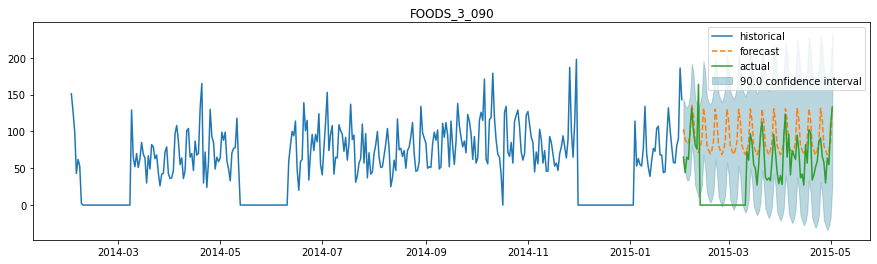

Item_id :  FOODS_3_120


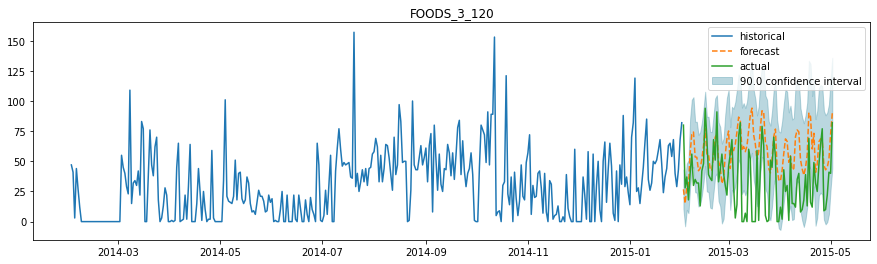

Item_id :  FOODS_3_252


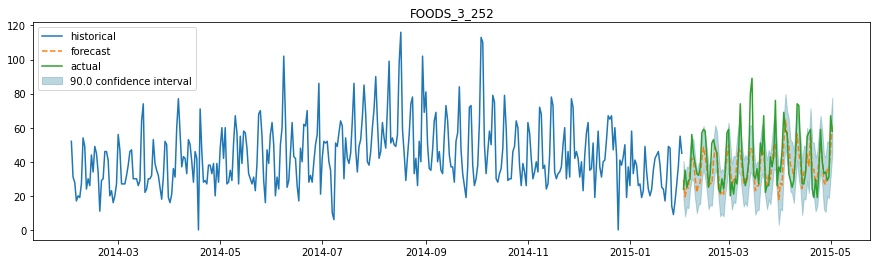

Item_id :  FOODS_3_586


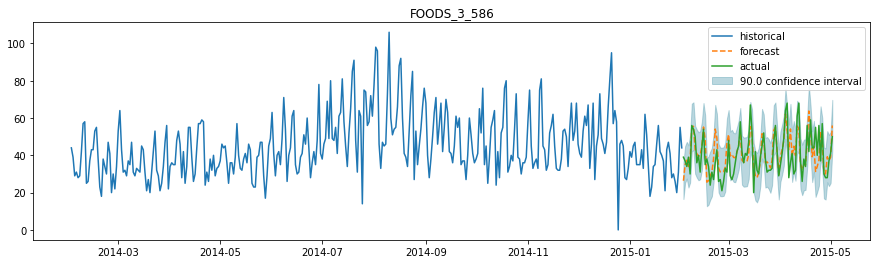

Item_id :  FOODS_3_714


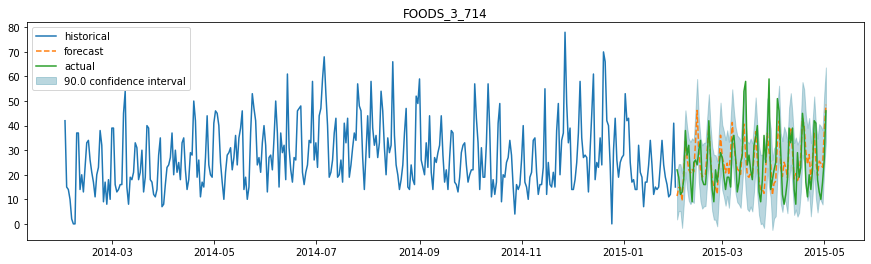

In [28]:
def plot_hist_forecast(historical, forecast, actual, hist_start="", hist_end="", title="") :
    if hist_start != "":
        historical = historical[historical["date"] >= pd.to_datetime(hist_start,format="%Y-%m-%d")].copy()
    if hist_end != "":
        historical = historical[historical["date"] <= pd.to_datetime(hist_end,format="%Y-%m-%d")].copy()
        
    plt.figure(figsize=(15,4))
    plt.plot(historical["date"], historical["sales_count"], label="historical")
    # Plot the forecast data
    plt.plot(forecast["forecast_timestamp"], forecast["forecast_value"], label="forecast", linestyle='--')
    # Plot the actual data
    plt.plot(actual["date"], actual["sales_count"], label="actual")
    ## plot the confidence interval
    confidence_level = forecast['confidence_level'].iloc[0] * 100
    low_CI = forecast['confidence_interval_lower_bound']
    upper_CI = forecast['confidence_interval_upper_bound']
    
    # Shade the confidence interval
    plt.fill_between(forecast["forecast_timestamp"], low_CI, upper_CI, color = '#539caf', alpha = 0.4, 
                     label = f'{confidence_level} confidence interval')
    plt.legend()
    plt.title(title)
    plt.show()
    return

item_id_list = dfforecast["item_id"].unique()
for i in item_id_list :
    print ("Item_id : ", i)
    plot_hist_forecast(df_historical[df_historical["item_id"] == i], 
                       dfforecast[dfforecast["item_id"]==i], 
                       df_actual_90d[df_actual_90d["item_id"]==i],
                       hist_start="2014-02-01", title=i)

While most of the predictions are looking decent, you can also see that the actual ranges fall into the 90% confidence interval suggested by the model. Under the hood, BQML performs many computationally expensive tasks even considering the seasonal and holiday information.
<img src="https://cloud.google.com/bigquery-ml/images/BQ_ARIMA_diagram.png"> <a href="https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-time-series"> Source</a> </img>

The coefficients learned by BQML's ARIMA model can also be checked by simply querying for <a href="https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-arima-coefficients">ARIMA_COEFFICIENTS</a> from the model.

#@bigquery
SELECT
  *
FROM 
  ML.ARIMA_COEFFICIENTS(MODEL demand_forecasting.arima_model)

In the above results, 
- <b>item_id</b> column represents the index column we've specified while training the ARIMA model.
- <b>ar_coefficients</b> column corresponds to the autoregressive coefficients in the ARIMA algorithm(non-seasonal p).
- <b>ma_coefficients</b> refers to the moving average coefficients in the ARIMA algorithm(non-seasonal q).
- <b>intercept_or_drift</b> is the constant term in the ARIMA algorithm.

## Evaluating the model results using BQML (on Training Data)
<a name="section-8-subsection-1"></a>


Nevertheless, BQML also provies us with the <a href="https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-evaluate">ML.EVALUATE</a> function to see check the evaluation metrics of the trained model. For ARIMA model, we can see the model being evaluated on log_likelihood, AIC and variance measures. 

#@bigquery
SELECT
  *
FROM
  ML.EVALUATE(MODEL demand_forecasting.arima_model)

## Evaluting the model results - MAE, MAPE, MSE, RMSE (on Test data)
<a name="section-8-subsection-2"></a>


Generally, to evaluate forecast model, we have various metrics depending on how we want to evaluate. For starters, we can choose from the following : 
* <b>Mean Absolute Error (MAE)</b> : Average of the absolute differences between the actual values and the forecasted values.
* <b>Mean Absolute Percentage Error (MAPE)</b> : Average of the percentages of absolute difference between the actual and forecasted values to the actual values.
* <b>Mean Squared Error (MSE)</b> : Average of squared differences between the actual and forecasted values.
* <b>Root Mean Squared Error (RMSE)</b> : Root of MSE

In [29]:

df_actual_90d.sort_values(by=["item_id","date"], inplace=True)
df_actual_90d.reset_index(drop=True, inplace=True)
dfforecast.sort_values(by=["item_id", "forecast_timestamp"], inplace=True)
dfforecast.reset_index(drop=True, inplace=True)

In [30]:
errors = {"item_id":[], "MAE":[], "MAPE":[], "MSE":[], "RMSE":[]}
for i in item_id_list :
    mae = mean_absolute_error(df_actual_90d[df_actual_90d["item_id"]==i]["sales_count"],
                             dfforecast[dfforecast["item_id"]==i]["forecast_value"])
    mape = mean_absolute_percentage_error(df_actual_90d[df_actual_90d["item_id"]==i]["sales_count"],
                             dfforecast[dfforecast["item_id"]==i]["forecast_value"])
    mse = mean_squared_error(df_actual_90d[df_actual_90d["item_id"]==i]["sales_count"],
                             dfforecast[dfforecast["item_id"]==i]["forecast_value"],squared=True)
    rmse = mean_squared_error(df_actual_90d[df_actual_90d["item_id"]==i]["sales_count"],
                             dfforecast[dfforecast["item_id"]==i]["forecast_value"],squared=False)
    errors["item_id"].append(i)
    errors["MAE"].append(mae)
    errors["MAPE"].append(mape)
    errors["MSE"].append(mse)
    errors["RMSE"].append(rmse)
errors = pd.DataFrame(errors)
errors

,item_id,MAE,MAPE,MSE,RMSE
0,FOODS_3_090,46.760106,1.267433e+17,3389.083850,58.215838
1,FOODS_3_120,28.617572,2.780878e+16,1221.065188,34.943743
2,FOODS_3_252,9.275188,2.277477e-01,150.544926,12.269675
3,FOODS_3_586,6.348818,1.731787e-01,71.210781,8.438648
4,FOODS_3_714,6.969436,3.524324e-01,84.898623,9.214045


From the values obtained for various error measures, you can identify that for the first two item ids i.e., "FOODS_3_090" and "FOODS_3_120", the forecasted values are way off (at least at some point of time during the 90 days). We can also examine from their plots why their error measures are high. It has to be noted that these error measures are an aggregate of all the individual forecasts made during the test period and so we get an overall picture of the model's performance over the selected period. Ideally, the lower these error measures, the better the model is good at forecasting.

## Clean up
<a name="section-9"></a>


To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial(The following code deletes entire dataset).



In [ ]:

# Construct a BigQuery client object.
client = bigquery.Client()

# TODO(developer): Set model_id to the ID of the model to fetch.
dataset_id = 'your-project-id.dataset-name'

# Use the delete_contents parameter to delete a dataset and its contents.
# Use the not_found_ok parameter to not receive an error if the dataset has already been deleted.
client.delete_dataset(
    dataset_id, delete_contents=True, not_found_ok=True
)  # Make an API request.

print("Deleted dataset '{}'.".format(dataset_id))